In [16]:
!mkdir /tmp/stanford-corenlp
!wget -q https://nlp.stanford.edu/software/stanford-corenlp-4.5.1.zip -P /tmp/stanford-corenlp
!unzip -qq -o /tmp/stanford-corenlp/stanford-corenlp-4.5.1.zip -d /tmp

mkdir: cannot create directory ‘/tmp/stanford-corenlp’: File exists
--2022-11-12 02:30:49--  https://nlp.stanford.edu/software/stanford-corenlp-4.5.1.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://downloads.cs.stanford.edu/nlp/software/stanford-corenlp-4.5.1.zip [following]
--2022-11-12 02:30:50--  https://downloads.cs.stanford.edu/nlp/software/stanford-corenlp-4.5.1.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 505225173 (482M) [application/zip]
Saving to: ‘/tmp/stanford-corenlp/stanford-corenlp-4.5.1.zip’

stanford-corenlp-4. 100%[===================>] 481.82M  5.12MB/s    in 93s     

2022-11-12 02:32:24 (5.20 MB/s) - ‘/tmp/s

In [28]:
%pylab inline

import hashlib
import os
import tempfile

import numpy as np
import pandas as pd
import pymysql
import seaborn as sns
import sqlalchemy


def query(sql, user="anderson", password="1234567890", host="localhost"):
    base_dir = os.path.join(tempfile.gettempdir(), "yelp")
    hash_key = hashlib.sha1(sql.encode("utf-8")).hexdigest()
    file_path = os.path.join(base_dir, hash_key + ".csv")
    if not os.path.exists(base_dir):
        os.mkdir(base_dir)

    if os.path.exists(file_path):
        data = pd.read_csv(file_path, index_col=0)
    else:
        engine = sqlalchemy.create_engine(
            f"mysql+pymysql://{user}:{password}@{host}:3306/yelp"
        )
        data = pd.read_sql(sql, con=engine)
        data.to_csv(file_path)
    return data

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [29]:
# Initialize Stanford
from pathlib import Path

import nltk
from nltk import corpus
from nltk.tag.stanford import StanfordNERTagger

nltk.download("stopwords")

base = Path("app/stanford-ner-2018-10-16")
gz = [
    os.path.join(base, "classifiers/english.all.3class.distsim.crf.ser.gz"),
    os.path.join(base, "stanford-ner.jar"),
]
tagger = StanfordNERTagger(*gz)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/anderson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


LookupError: Could not find stanford-ner.jar jar file at ~/app/stanford-ner-2018-10-16/stanford-ner.jar

# EDA

## Yelp 는 잘하고 있는가?

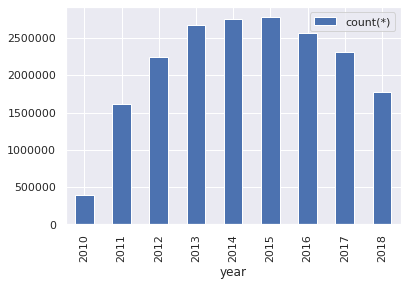

In [111]:
sql = """select year, count(*) from checkin
group by year
order by year;"""
df = query(sql)
df.plot(x="year", kind="bar")

## 가장 많은 상점 이름

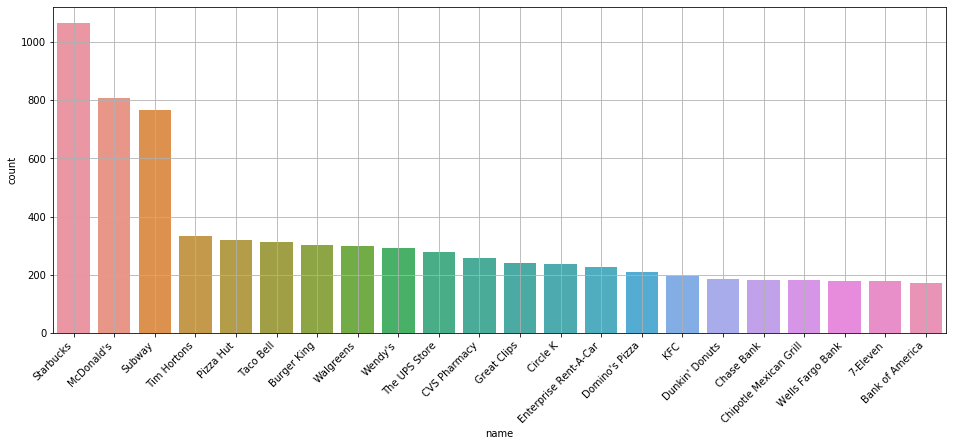

In [29]:
sql = """select name, count(*) count
from business
group by name
having count(*) > 10
order by count(*) DESC 
limit 22"""
df = query(sql)

fig, ax = subplots(figsize=(16, 6))
cht = sns.barplot(x="name", y="count", data=df, ax=ax)
cht.set_xticklabels(cht.get_xticklabels(), rotation=45, horizontalalignment="right")
grid()

## 산업, 지역별 별점

In [82]:
sql = r"""select CASE
         WHEN name REGEXP '(hotel|motel| inn)' then 'hotel'
         WHEN name REGEXP 'starbucks' then 'starbucks'
         WHEN categories like '%restaurants%' then 'restaurants'
         ELSE 'etc'
         END             industry,
       state,
       avg(stars)        avg_star,
       avg(review_count) avg_review_count,
       std(stars)        std_star,
       sum(is_open)      sum_open,
       avg(rank) avg_rank
from business
group by 1, 2
order by 1, 7 DESC""".replace(
    "%", "%%"
)
df = query(sql)
df

,industry,state,avg_star,avg_review_count,std_star,sum_open,avg_rank
0,etc,FL,2.666667,229.3333,1.312335,2.0,367.666667
1,etc,NV,3.767567,30.1042,1.072630,24137.0,114.577318
2,etc,AZ,3.784956,18.7583,1.096276,38781.0,71.007107
3,etc,CA,4.083333,13.5000,1.304373,16.0,53.972222
4,etc,NY,3.000000,19.4444,1.247219,9.0,53.500000
...,...,...,...,...,...,...,...
75,starbucks,OH,3.531646,15.4684,0.657680,70.0,53.075949
76,starbucks,PA,3.387931,15.4828,0.650219,55.0,52.862069
77,starbucks,ON,3.429658,10.7300,0.592888,227.0,36.836502
78,starbucks,QC,3.583333,6.4375,0.671855,44.0,22.645833


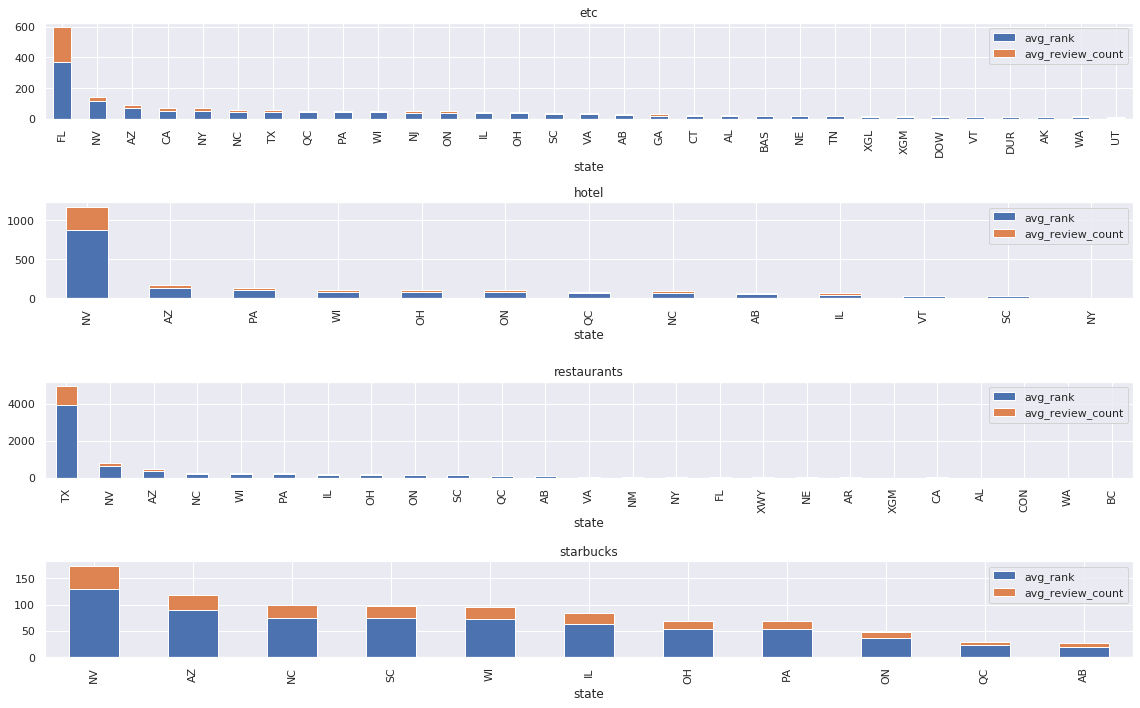

In [89]:
fig, plots = subplots(4, 1, figsize=(16, 10))
fig.set_tight_layout(True)
plots = plots.reshape(-1)

for i, industry in enumerate(df["industry"].unique()):
    p = plots[i]
    df2 = df[df["industry"] == industry][["state", "avg_rank", "avg_review_count"]]
    df2.set_index("state").plot(kind="bar", stacked=True, title=industry, ax=p)

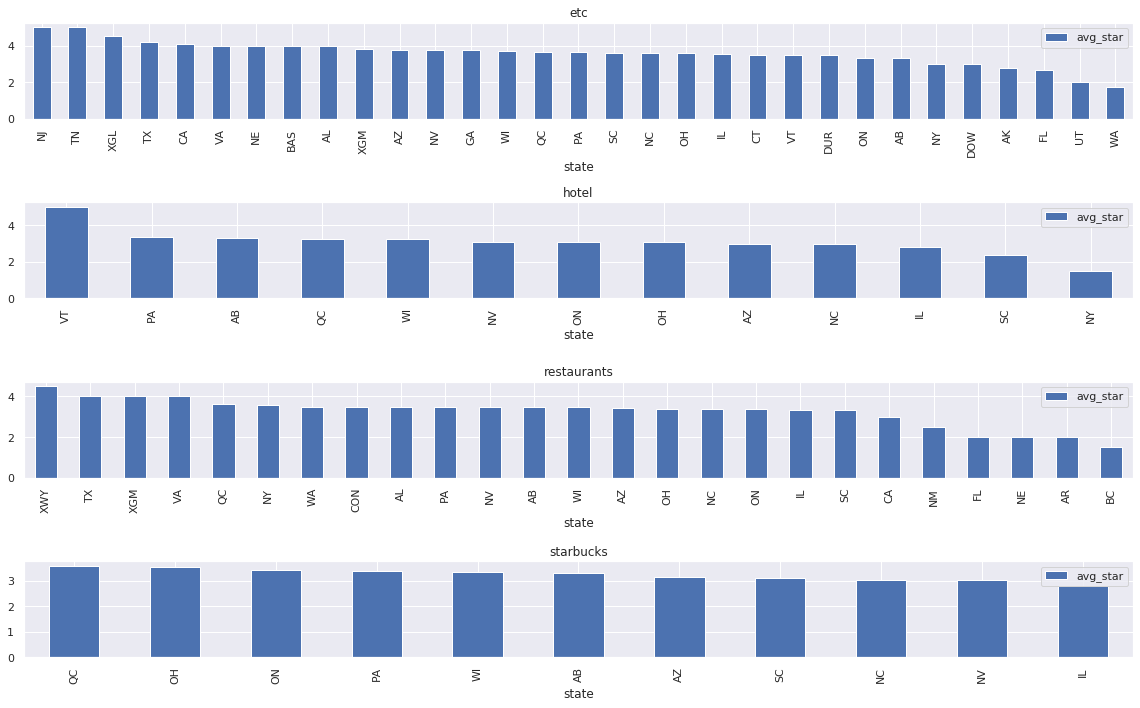

In [96]:
fig, plots = subplots(4, 1, figsize=(16, 10))
fig.set_tight_layout(True)
plots = plots.reshape(-1)

for i, industry in enumerate(df["industry"].unique()):
    p = plots[i]
    df2 = df[df["industry"] == industry][["state", "avg_star"]]
    df2 = df2.sort_values("avg_star", ascending=False)
    df2.set_index("state").plot(kind="bar", stacked=True, title=industry, ax=p)

## 랭킹 - 대중적이면서 스타 등급이 높은 호텔

In [105]:
sql = """
select business_id,
       name,
       city,
       state,
       latitude,
       longitude,
       stars,
       review_count,
       is_open,
       rank
from business
where name REGEXP '(hotel|motel| inn)'
order by rank
  DESC
limit 10;"""

df = query(sql)
df

,business_id,name,city,state,latitude,longitude,stars,review_count,is_open,rank
0,El4FC8jcawUVgw_0EIcbaQ,MGM Grand Hotel,Las Vegas,NV,36.102251,-115.169968,3.0,3944,1,11832.0
1,na4Th5DrNauOv-c43QQFvA,Bellagio Hotel,Las Vegas,NV,36.112629,-115.176706,3.5,3187,1,11154.5
2,AV6weBrZFFBfRGCbcRGO4g,Luxor Hotel and Casino Las Vegas,Las Vegas,NV,36.097341,-115.176339,2.5,4117,1,10292.5
3,WYw3Uf56DT5IwpaLNnCH5Q,Vdara Hotel & Spa at ARIA Las Vegas,Las Vegas,NV,36.109301,-115.178147,4.0,2543,1,10172.0
4,EAwh1OmG6t6p3nRaZOW_AA,"Ellis Island Hotel, Casino & Brewery",Las Vegas,NV,36.112996,-115.163396,4.0,2190,1,8760.0
5,u_vPjx925UPEG9DFOAAvFQ,Flamingo Las Vegas Hotel & Casino,Las Vegas,NV,36.116208,-115.170781,2.5,3478,1,8695.0
6,VyjyHoBg3KC5BSFRlD0ZPQ,Caesars Palace Las Vegas Hotel & Casino,Las Vegas,NV,36.116765,-115.174595,3.0,2834,1,8502.0
7,ii8sAGBexBOJoYRFafF9XQ,Paris Las Vegas Hotel & Casino,Las Vegas,NV,36.112358,-115.170221,3.0,2513,1,7539.0
8,bsrj9_hFAql3dlSf244zpg,Trump International Hotel Las Vegas,Las Vegas,NV,36.129559,-115.172825,4.0,1842,1,7368.0
9,o7AiTlyWUrBSzdz6oMHj5w,Excalibur Hotel,Las Vegas,NV,36.098732,-115.174726,2.5,2889,1,7222.5


In [106]:
sql = """
select business_id,
       name,
       city,
       state,
       latitude,
       longitude,
       stars,
       review_count,
       is_open,
       pow(stars, 1.5) * pow(review_count, 0.6) as rank2
from business
where name REGEXP '(hotel|motel| inn)'
order by rank2
  DESC
limit 10;"""

df = query(sql)
df

,business_id,name,city,state,latitude,longitude,stars,review_count,is_open,rank2
0,WYw3Uf56DT5IwpaLNnCH5Q,Vdara Hotel & Spa at ARIA Las Vegas,Las Vegas,NV,36.109301,-115.178147,4.0,2543,1,883.685651
1,na4Th5DrNauOv-c43QQFvA,Bellagio Hotel,Las Vegas,NV,36.112629,-115.176706,3.5,3187,1,828.192522
2,EAwh1OmG6t6p3nRaZOW_AA,"Ellis Island Hotel, Casino & Brewery",Las Vegas,NV,36.112996,-115.163396,4.0,2190,1,807.897857
3,El4FC8jcawUVgw_0EIcbaQ,MGM Grand Hotel,Las Vegas,NV,36.102251,-115.169968,3.0,3944,1,746.868299
4,bsrj9_hFAql3dlSf244zpg,Trump International Hotel Las Vegas,Las Vegas,NV,36.129559,-115.172825,4.0,1842,1,728.221945
5,VyjyHoBg3KC5BSFRlD0ZPQ,Caesars Palace Las Vegas Hotel & Casino,Las Vegas,NV,36.116765,-115.174595,3.0,2834,1,612.522138
6,AV6weBrZFFBfRGCbcRGO4g,Luxor Hotel and Casino Las Vegas,Las Vegas,NV,36.097341,-115.176339,2.5,4117,1,582.986547
7,ii8sAGBexBOJoYRFafF9XQ,Paris Las Vegas Hotel & Casino,Las Vegas,NV,36.112358,-115.170221,3.0,2513,1,569.898318
8,p0iEUamJVp_QpaheE-Nz_g,"South Point Hotel, Casino & Spa",Las Vegas,NV,36.011357,-115.175775,3.5,1613,1,550.405401
9,eEnNw3_hBvxcFHyr23kAuA,Hard Rock Hotel & Casino,Las Vegas,NV,36.109230,-115.154036,3.0,2277,1,537.155096


## Counting useful, cool, funny

,count(*),useful,funny,cool,useful_pct,funny_pct,cool_pct,all_pct
0,6685900,3115446.0,1373727.0,1672612.0,0.466,0.2055,0.2502,0.5256


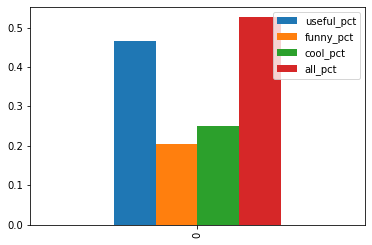

In [69]:
sql = """
select count(*),
       sum(case when useful > 0 then 1 else 0 end)                                     useful,
       sum(case when funny > 0 then 1 else 0 end)                                      funny,
       sum(case when cool > 0 then 1 else 0 end)                                       cool,
       sum(case when useful > 0 then 1 else 0 end) / count(*)                          useful_pct,
       sum(case when funny > 0 then 1 else 0 end) / count(*)                           funny_pct,
       sum(case when cool > 0 then 1 else 0 end) / count(*)                            cool_pct,
       sum(case when useful > 0 or funny > 0 or cool > 0 then 1 else 0 end) / count(*) all_pct
from review;"""
df = query(sql)
display(df)
df.plot(y=["useful_pct", "funny_pct", "cool_pct", "all_pct"], kind="bar")

## 비즈니스 stars 와 댓글과의 관계

In [322]:
sql = """
select cast(b.stars as int)                                                            business_star,
       avg(b.rank)                                                                     rank_avg,
       avg(pow(b.stars, 1.5) * pow(b.review_count, 0.6))                               rank2_avg,
       avg(b.review_count)                                                             avg_review_count,
       avg(r.stars)                                                                    avg_star_rv,
       avg(r.useful)                                                                   avg_useful_rv,
       avg(r.funny)                                                                    avg_funny_rv,
       avg(r.cool)                                                                     avg_cool_rv,
       avg(r.useful + r.funny + r.cool)                                                avg_ufc,
       avg(r.funny + r.cool)                                                           avg_fc,
       sum(case when r.useful > 0 then 1 else 0 end)                                   useful_cnt,
       sum(case when r.funny > 0 then 1 else 0 end)                                    funny_cnt,
       sum(case when r.cool > 0 then 1 else 0 end)                                     cool_cnt,
       sum(case when useful > 0 or funny > 0 or cool > 0 then 1 else 0 end)            all_cnt,
       sum(case when r.useful > 0 then 1 else 0 end) / count(*)                        useful_pct,
       sum(case when r.funny > 0 then 1 else 0 end) / count(*)                         funny_pct,
       sum(case when r.cool > 0 then 1 else 0 end) / count(*)                          cool_pct,
       sum(case when useful > 0 or funny > 0 or cool > 0 then 1 else 0 end) / count(*) all_pct
from review r
       join business b on b.business_id = r.business_id
group by cast(b.stars as int)"""
df = query(sql)
df

,business_star,rank_avg,rank2_avg,avg_review_count,avg_star_rv,avg_useful_rv,avg_funny_rv,avg_cool_rv,avg_ufc,avg_fc,useful_cnt,funny_cnt,cool_cnt,all_cnt,useful_pct,funny_pct,cool_pct,all_pct
0,1,13.007984,4.334563,13.0080,1.105788,1.319361,0.491018,0.187625,1.998004,0.678643,275.0,105.0,59.0,294.0,0.5489,0.2096,0.1178,0.5868
1,2,4527.769615,312.126780,1812.5871,2.449194,1.457780,0.705221,0.516566,2.679567,1.221787,19594.0,10902.0,8714.0,22204.0,0.5052,0.2811,0.2247,0.5725
2,3,4600.572258,366.099649,1533.5241,3.017583,1.539018,0.688427,0.655944,2.883389,1.344371,16511.0,8788.0,8270.0,18621.0,0.5212,0.2774,0.2611,0.5878
3,4,3115.266878,332.062776,826.9159,3.789379,1.437758,0.572550,0.672859,2.683166,1.245409,21515.0,10071.0,11741.0,24044.0,0.5040,0.2359,0.2750,0.5632
4,5,216.652299,95.678638,43.3305,4.875000,1.326149,0.293103,0.550287,2.169540,0.843391,335.0,95.0,171.0,364.0,0.4813,0.1365,0.2457,0.5230


In [323]:
df = df[df["business_star"] < 5]

,business_star,rank_avg,rank2_avg,avg_review_count,avg_star_rv,avg_useful_rv,avg_funny_rv,avg_cool_rv,avg_ufc,avg_fc,useful_cnt,funny_cnt,cool_cnt,all_cnt,useful_pct,funny_pct,cool_pct,all_pct
rank2_avg,0.798422,0.947615,1.000000,0.840330,0.884871,0.922246,0.807810,0.971510,0.991291,0.998592,0.948030,0.952756,0.932007,0.949006,-0.873653,0.801796,0.969288,-0.431366
avg_fc,0.782705,0.954096,0.998592,0.848957,0.868807,0.941438,0.822593,0.966743,0.996878,1.000000,0.930168,0.939099,0.912201,0.931433,-0.848208,0.818083,0.961722,-0.382914
avg_ufc,0.753202,0.959842,0.991291,0.859310,0.838963,0.965123,0.842226,0.953739,1.000000,0.996878,0.899008,0.914649,0.877617,0.900739,-0.806602,0.839946,0.944628,-0.308800
avg_cool_rv,0.915506,0.846511,0.971510,0.688273,0.962620,0.867487,0.649809,1.000000,0.953739,0.966743,0.926252,0.895795,0.950401,0.924353,-0.839571,0.643982,0.998533,-0.481788
cool_pct,0.921942,0.839969,0.969288,0.682652,0.971009,0.845227,0.638150,0.998533,0.944628,0.961722,0.941366,0.908254,0.965577,0.939305,-0.863731,0.630752,1.000000,-0.528219
funny_cnt,0.719667,0.924152,0.952756,0.857498,0.834899,0.792213,0.799338,0.895795,0.914649,0.939099,0.988216,1.000000,0.949503,0.990017,-0.971339,0.785494,0.908254,-0.616143
all_cnt,0.801475,0.875596,0.949006,0.779344,0.897103,0.758228,0.713059,0.924353,0.900739,0.931433,0.999925,0.990017,0.983710,1.000000,-0.981534,0.698114,0.939305,-0.683802
useful_cnt,0.808061,0.870763,0.948030,0.771936,0.901847,0.755032,0.705077,0.926252,0.899008,0.930168,1.000000,0.988216,0.985794,0.999925,-0.981339,0.690071,0.941366,-0.688558
rank_avg,0.564281,1.000000,0.947615,0.967967,0.691710,0.935482,0.953487,0.846511,0.959842,0.954096,0.870763,0.924152,0.803739,0.875596,-0.808379,0.949678,0.839969,-0.269776
cool_cnt,0.893113,0.803739,0.932007,0.668228,0.959031,0.723257,0.597985,0.950401,0.877617,0.912201,0.985794,0.949503,1.000000,0.983710,-0.956694,0.583338,0.965577,-0.718612


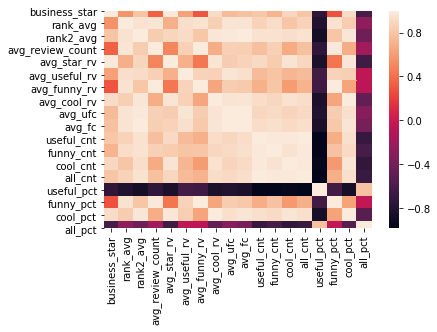

In [324]:
corr = df.corr()
corr = corr.reindex(corr["rank2_avg"].abs().sort_values(ascending=False).index)
display(corr)
sns.heatmap(df.corr())

## Word Cloud for Category

In [150]:
import nltk
from nltk.corpus import stopwords
from wordcloud import STOPWORDS, ImageColorGenerator, WordCloud

nltk.download("stopwords")

stopwords = set(stopwords.words("english")) | set(STOPWORDS)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/anderson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


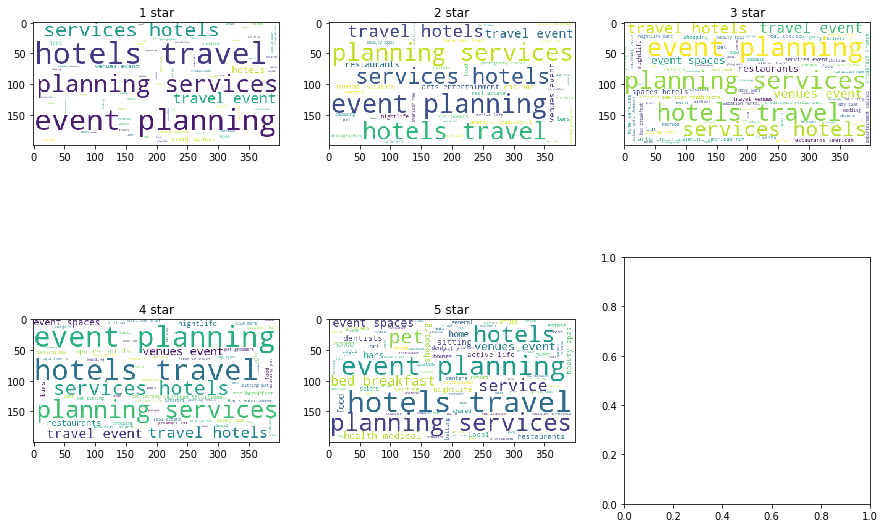

In [307]:
sql = """select * from business"""
df = query(sql)
df["stars"] = df["stars"].astype("int")

fig, plots = subplots(2, 3, figsize=(15, 10))
plots = plots.reshape(-1)
for i in range(5):
    star_df = df[df["stars"] == i + 1]
    string = star_df["categories"].str.cat(sep=" ")
    wordcloud = WordCloud(background_color="white").generate(string)
    plots[i].imshow(wordcloud)
    plots[i].set_title(f"{i+1} star")